2026-02-23:20:02:58 [INFO    ] [prototype.py:124] {'amp': False,
 'attack': 'badnet',
 'attack_label_trans': 'all2one',
 'attack_target': 0,
 'batch_size': 128,
 'bd_yaml_path': './config/attack/badnet/default.yaml',
 'client_optimizer': 'sgd',
 'dataset': 'cifar10',
 'dataset_path': './data/cifar10',
 'device': 'cuda:0',
 'epochs': 100,
 'frequency_save': 0,
 'img_size': (32, 32, 3),
 'input_channel': 3,
 'input_height': 32,
 'input_width': 32,
 'lr': 0.01,
 'lr_scheduler': 'CosineAnnealingLR',
 'model': 'preactresnet18',
 'non_blocking': True,
 'num_classes': 10,
 'num_workers': 4,
 'patch_mask_path': './resource/badnet/trigger_image.png',
 'pin_memory': True,
 'pratio': 0.1,
 'prefetch': False,
 'random_seed': 0,
 'save_path': './record/20260223_200258_ipykernel_launcher_attack_badnet_xHfF',
 'sgd_momentum': 0.9,
 'terminal_info': ['C:\\Users\\Morris\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\i

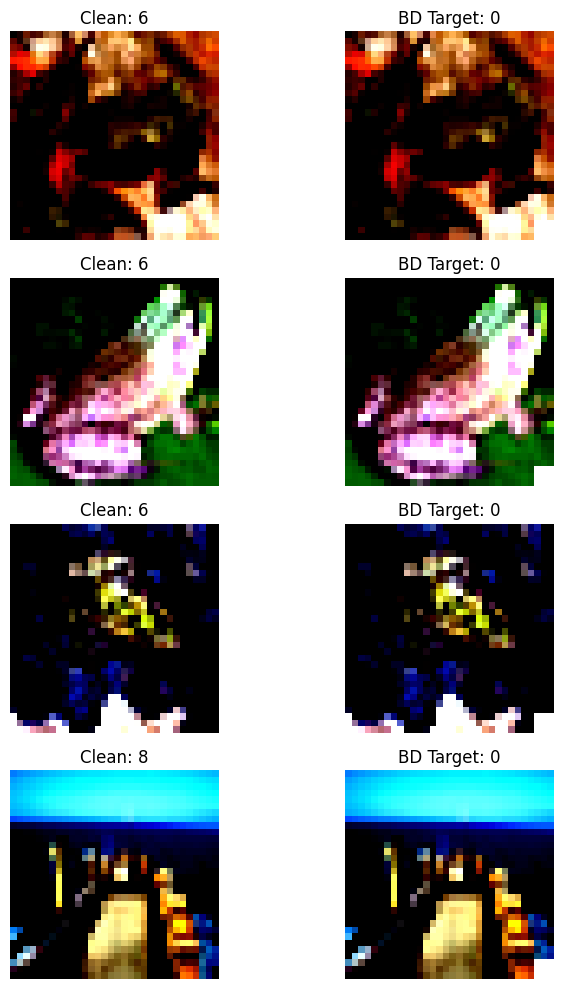

In [ ]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import sys
import argparse
from utils.aggregate_block.bd_attack_generate import bd_attack_img_trans_generate, bd_attack_label_trans_generate
from copy import deepcopy
from attack.badnet import BadNet

sys.path = ["./"] + sys.path

# Initialise BadNet attack instance
attack = BadNet()
parser = argparse.ArgumentParser()
parser = attack.set_args(parser)
parser = attack.set_bd_args(parser)
args = parser.parse_args(["--dataset", "cifar10", "--attack", "badnet"])
attack.add_bd_yaml_to_args(args)
attack.add_yaml_to_args(args)
args = attack.process_args(args)
attack.prepare(args)
attack.stage1_non_training_data_prepare()


# 4-output data loader - used to output clean image/label and poisoned image/label
class ViTAnalysisTestDataset(torch.utils.data.Dataset):
    def __init__(self, raw_dataset, bd_img_trans, bd_lbl_trans, clean_trans):
        self.raw_dataset = raw_dataset  # raw test data
        self.bd_img_trans = bd_img_trans  # add backdoor patch
        self.bd_lbl_trans = bd_lbl_trans  # all2one attack
        self.clean_trans = clean_trans  # test image transforms.Compose (e.g. normalisation)

    def __getitem__(self, index):
        # Get raw image
        img_raw, label_clean = self.raw_dataset[index]
        
        # Create backdoor version of image and label
        img_bd_raw = self.bd_img_trans(deepcopy(img_raw))
        label_bd = self.bd_lbl_trans(label_clean)
        
        # Apply same transform on both clean and backdoor test data (ViTs need normalization from test_img_transform)
        img_clean_tensor = self.clean_trans(img_raw)
        img_bd_tensor = self.clean_trans(img_bd_raw)
        
        return img_clean_tensor, label_clean, img_bd_tensor, label_bd

    def __len__(self):
        return len(self.raw_dataset)


# BadNet-style attack preparation
(
    train_dataset_without_transform,  # raw train dataset without augmentation loaded directly from torchvision
    train_img_transform,  # torchvision.transforms composition (e.g. Resize, Normalize, ToTensor, Crop, Horizontal Flip)
    train_label_transform,  # No transform on label
    test_dataset_without_transform,  # raw test dataset without augmentation loaded directly from torchvision
    test_img_transform,  # torchvision.transforms composition (e.g. Resize, ToTensor)
    test_label_transform,  # No transform on label
    *others  # Discard the others as they are wrappers
) = attack.benign_prepare()


# Get the specific backdoor transformation logic
_, test_bd_img_transform = bd_attack_img_trans_generate(args) # add backdoor patch
bd_label_transform = bd_attack_label_trans_generate(args) # all2one attack


analysis_dataset = ViTAnalysisTestDataset(
    raw_dataset=test_dataset_without_transform,  # raw test dataset without augmentation loaded directly from torchvision
    bd_img_trans=test_bd_img_transform,  # add backdoor patch
    bd_lbl_trans=bd_label_transform,  # all2one attack
    clean_trans=test_img_transform  # test image transforms.Compose
)
analysis_loader = DataLoader(analysis_dataset, batch_size=4, shuffle=True)


# Plot clean and backdoor images and labels
def plot_vits_data(loader):
    img_c, lbl_c, img_b, lbl_b = next(iter(loader))
    
    fig, axes = plt.subplots(len(img_c), 2, figsize=(8, 10))
    for i in range(len(img_c)):
        # Display clean image and label
        axes[i, 0].imshow(img_c[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title(f"Clean: {lbl_c[i]}")
        axes[i, 0].axis('off')
        
        # Display backdoored image and label
        axes[i, 1].imshow(img_b[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"BD Target: {lbl_b[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


plot_vits_data(analysis_loader)